## Miller ECoG data of motor imagery

## Data retrieval

In [1]:
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 12.8 MB/s eta 0:00:00


alldat is two dimensional; first dimension is for participant index and second for the type of task (0 for motor and 1 for imagery):

In [3]:
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings
dat1 = alldat[0][0] # motor tasks
dat2 = alldat[0][1] # imagery tasks

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [4]:
motor_data = [dat[0] for dat in alldat]
imagery_data = [dat[1] for dat in alldat]

In [5]:
len(imagery_data)

7

In [6]:
len(motor_data)

7

filter data for selected broadmann areas:

In [7]:
ba_filter = ['Brodmann area 2', 'Brodmann area 4', 'Brodmann area 6', 'Brodmann area 9', 'Brodmann area 43', 'Brodmann area 45']

filtered_motor_data = []
for dat in motor_data:
    ba = np.array(dat['Brodmann_Area'])
    filtered_electrodes_idx = [i for i, area in enumerate(ba) if area in ba_filter]

    filtered_data = {}
    for key in dat.keys():
        if isinstance(dat[key], np.ndarray) and dat[key].shape[-1] == len(dat['Brodmann_Area']):
            if dat[key].ndim == 1:
                 filtered_data[key] = dat[key][filtered_electrodes_idx]
            elif dat[key].ndim == 2:
                 filtered_data[key] = dat[key][:, filtered_electrodes_idx]
            else:
                 filtered_data[key] = dat[key]
        elif key == 'Brodmann_Area':
             filtered_data[key] = ba[filtered_electrodes_idx]
        else:
            filtered_data[key] = dat[key]

    filtered_motor_data.append(filtered_data)

print("Filtered motor data:")
for i, data in enumerate(filtered_motor_data):
    print(f"Participant {i+1}: {data['V'].shape[1]} electrodes, BA: {np.unique(data['Brodmann_Area'])}")

Filtered motor data:
Participant 1: 27 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodmann area 45'
 'Brodmann area 6' 'Brodmann area 9']
Participant 2: 24 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodmann area 45'
 'Brodmann area 6' 'Brodmann area 9']
Participant 3: 15 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodmann area 45'
 'Brodmann area 6' 'Brodmann area 9']
Participant 4: 28 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodmann area 45'
 'Brodmann area 6' 'Brodmann area 9']
Participant 5: 15 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodmann area 45'
 'Brodmann area 6' 'Brodmann area 9']
Participant 6: 32 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodmann area 45'
 'Brodmann area 6' 'Brodmann area 9']
Participant 7: 20 electrodes, BA: ['Brodmann area 2' 'Brodmann area 4' 'Brodmann area 43' 'Brodma

## Data Preprocessing

In [8]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.5 MB/s eta 0:00:00


In [9]:
import mne
from mne.viz import plot_alignment
from mne.time_frequency import tfr_morlet
import seaborn as sns
sns.set_style('white')

In [10]:
# Function to preprocess data
def preprocess_participant(dat):
    # Convert data to float32 and scale to μV
    data = dat['V'].astype(np.float32) * dat['scale_uv']
    # Create events array
    events = np.zeros((len(dat['t_on']), 3), dtype=int)
    events[:, 0] = dat['t_on']
    events[:, 2] = dat['stim_id']

    # Create channel names
    n_channels = len(dat['scale_uv'])
    ch_names = [f'ECoG_{i}' for i in range(n_channels)]

    # Create MNE info object
    info = mne.create_info(ch_names, dat['srate'], 'ecog')

    # Set custom montage from electrode locations
    montage = mne.channels.make_dig_montage(
        ch_pos=dict(zip(ch_names, dat['locs'])),
        coord_frame='head'
    )
    info.set_montage(montage)

    # Create Raw object
    raw = mne.io.RawArray(data.T, info)

    return raw, events, info

# Preprocess
all_participants = []
for i, dat in enumerate(filtered_motor_data):
    raw, events, info = preprocess_participant(dat)
    all_participants.append((raw, events, info))
    print(f"Participant {i+1} processed: {len(dat['t_on'])} trials, {len(dat['scale_uv'])} channels")

Creating RawArray with float64 data, n_channels=27, n_times=376400
    Range : 0 ... 376399 =      0.000 ...   376.399 secs
Ready.
Participant 1 processed: 60 trials, 27 channels
Creating RawArray with float64 data, n_channels=24, n_times=390680
    Range : 0 ... 390679 =      0.000 ...   390.679 secs
Ready.
Participant 2 processed: 60 trials, 24 channels
Creating RawArray with float64 data, n_channels=15, n_times=376240
    Range : 0 ... 376239 =      0.000 ...   376.239 secs
Ready.
Participant 3 processed: 60 trials, 15 channels
Creating RawArray with float64 data, n_channels=28, n_times=390720
    Range : 0 ... 390719 =      0.000 ...   390.719 secs
Ready.
Participant 4 processed: 60 trials, 28 channels
Creating RawArray with float64 data, n_channels=15, n_times=390640
    Range : 0 ... 390639 =      0.000 ...   390.639 secs
Ready.
Participant 5 processed: 60 trials, 15 channels
Creating RawArray with float64 data, n_channels=32, n_times=390720
    Range : 0 ... 390719 =      0.000 

## Fourier transformation + PCA


Observations from data:
- 7 participants in total
- 60 events/trials per participant
- unequal number of channels across participants
- Positions of channels also vary across participants (-> therefore filtered out selected broadmann areas in all participants )

Steps for transformation:
- compute per-epoch, per-channel power spectral densities(psd) using Welch's method
- flatten the psd to 1D
- apply PCA reduction
- extract y labels

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
def compute_psd_pca_for_participant(raw, events,
                                    event_id={'hand': 12, 'tongue': 11},
                                    tmin=-0.2, tmax=0.6, baseline=(-0.2, 0),
                                    fmin=1, fmax=200, n_fft=512,
                                    n_components=11):
    """
    1) Epoch raw data around events
    2) Compute one PSD per epoch/channel via Welch's method
    3) Flatten channel×frequency into a single vector per epoch
    4) Run PCA to reduce to n_components features
    """
    try:
        # Epoch
        epochs = mne.Epochs(
            raw, events, event_id,
            tmin=tmin, tmax=tmax,
            baseline=baseline,
            preload=True, verbose=False,
            reject_by_annotation=True
        )

        # PSD via Welch: one PSD per epoch
        spectrum = epochs.compute_psd(
            method="welch",
            fmin=fmin, fmax=fmax,
            n_fft=n_fft, n_overlap=n_fft // 2,
            picks='all',
            average=False,
            verbose=False
        )

        psd_data = spectrum.get_data(return_freqs=True)

        if isinstance(psd_data, tuple) and len(psd_data) == 2:
            psd, freqs = psd_data
        else:
            raise ValueError(f"Unexpected return format from spectrum.get_data()")

        print(f"    PSD shape: {psd.shape}")
        if len(psd.shape) == 4:
            psd = np.mean(psd, axis=-1)
        elif len(psd.shape) == 3:
            pass
        else:
            raise ValueError(f"Unexpected PSD shape: {psd.shape}")
        n_epochs, n_channels, n_freqs = psd.shape
        print(f"    Final PSD shape: {psd.shape}")

        # Flatten channel × frequency
        X = psd.reshape(n_epochs, n_channels * n_freqs)

        # PCA reduction
        max_components = min(n_epochs - 1, n_channels * n_freqs)
        actual_components = min(n_components, max_components)
        if actual_components != n_components:
            print(f"    Adjusting PCA components from {n_components} to {actual_components}")

        pca = PCA(n_components=actual_components)
        X_pca = pca.fit_transform(X)

        # Labels
        y = epochs.events[:, 2]
        return X_pca, y, freqs, pca

    except Exception as e:
        print(f"    Error in step: {e}")
        import traceback
        traceback.print_exc()
        raise

In [13]:
def create_dataset(all_participants,
                          fmin=30, fmax=150,
                          n_fft=512,
                          n_components=11,
                          standardize=True):
    """
    Create a unified dataset for training a single classifier across all participants.
    Handles different numbers of channels by using PCA to project to same dimensionality.
    """
    all_features = []
    all_labels = []
    participant_ids = []

    for idx, participant_data in enumerate(all_participants):
        print(f"Processing participant {idx+1}")

        try:
            # Handle different tuple structures
            if len(participant_data) == 2:
                raw, events = participant_data
            elif len(participant_data) == 3:
                raw, events, info = participant_data
            else:
                continue

            print(f"  - Raw data: {raw.info['nchan']} channels, {raw.n_times} samples")
            print(f"  - Events: {len(events)} events")

            X_pca, y, freqs, pca = compute_psd_pca_for_participant(
                raw, events,
                fmin=fmin, fmax=fmax,
                n_fft=n_fft,
                n_components=n_components
            )
            if standardize:
                scaler = StandardScaler()
                X_pca = scaler.fit_transform(X_pca)

            print(f"  - {X_pca.shape[0]} trials, {raw.info['nchan']} channels → {X_pca.shape[1]} PCA features")

            all_features.append(X_pca)
            all_labels.append(y)
            participant_ids.extend([idx] * len(y))

        except Exception as e:
            print(f"  - Error processing participant {idx+1}: {e}")
            import traceback
            traceback.print_exc()
            continue
    # Concatenate all data
    X_unified = np.vstack(all_features)
    y_unified = np.concatenate(all_labels)
    participant_ids = np.array(participant_ids)

    print(f"\ndataset: {X_unified.shape[0]} trials × {X_unified.shape[1]} features")
    print(f"Class distribution: {np.bincount(y_unified)}")

    return X_unified, y_unified, participant_ids

In [14]:
X_unified, y_unified, participant_ids = create_dataset(
    all_participants,
    fmin=30, fmax=150,
    n_fft=512,
    n_components=11,
    standardize=True
)

Processing participant 1
  - Raw data: 27 channels, 376400 samples
  - Events: 60 events
    PSD shape: (60, 27, 61, 2)
    Final PSD shape: (60, 27, 61)
  - 60 trials, 27 channels → 11 PCA features
Processing participant 2
  - Raw data: 24 channels, 390680 samples
  - Events: 60 events
    PSD shape: (60, 24, 61, 2)
    Final PSD shape: (60, 24, 61)
  - 60 trials, 24 channels → 11 PCA features
Processing participant 3
  - Raw data: 15 channels, 376240 samples
  - Events: 60 events
    PSD shape: (60, 15, 61, 2)
    Final PSD shape: (60, 15, 61)
  - 60 trials, 15 channels → 11 PCA features
Processing participant 4
  - Raw data: 28 channels, 390720 samples
  - Events: 60 events
    PSD shape: (60, 28, 61, 2)
    Final PSD shape: (60, 28, 61)
  - 60 trials, 28 channels → 11 PCA features
Processing participant 5
  - Raw data: 15 channels, 390640 samples
  - Events: 60 events
    PSD shape: (60, 15, 61, 2)
    Final PSD shape: (60, 15, 61)
  - 60 trials, 15 channels → 11 PCA features
Proce

/tmp/ipython-input-12-4129486685.py:23: UserWarning: Zero value in spectrum for channel ECoG_21
  spectrum = epochs.compute_psd(


    PSD shape: (60, 32, 61, 2)
    Final PSD shape: (60, 32, 61)
  - 60 trials, 32 channels → 11 PCA features
Processing participant 7
  - Raw data: 20 channels, 390240 samples
  - Events: 60 events
    PSD shape: (60, 20, 61, 2)
    Final PSD shape: (60, 20, 61)
  - 60 trials, 20 channels → 11 PCA features

dataset: 420 trials × 11 features
Class distribution: [  0   0   0   0   0   0   0   0   0   0   0 210 210]


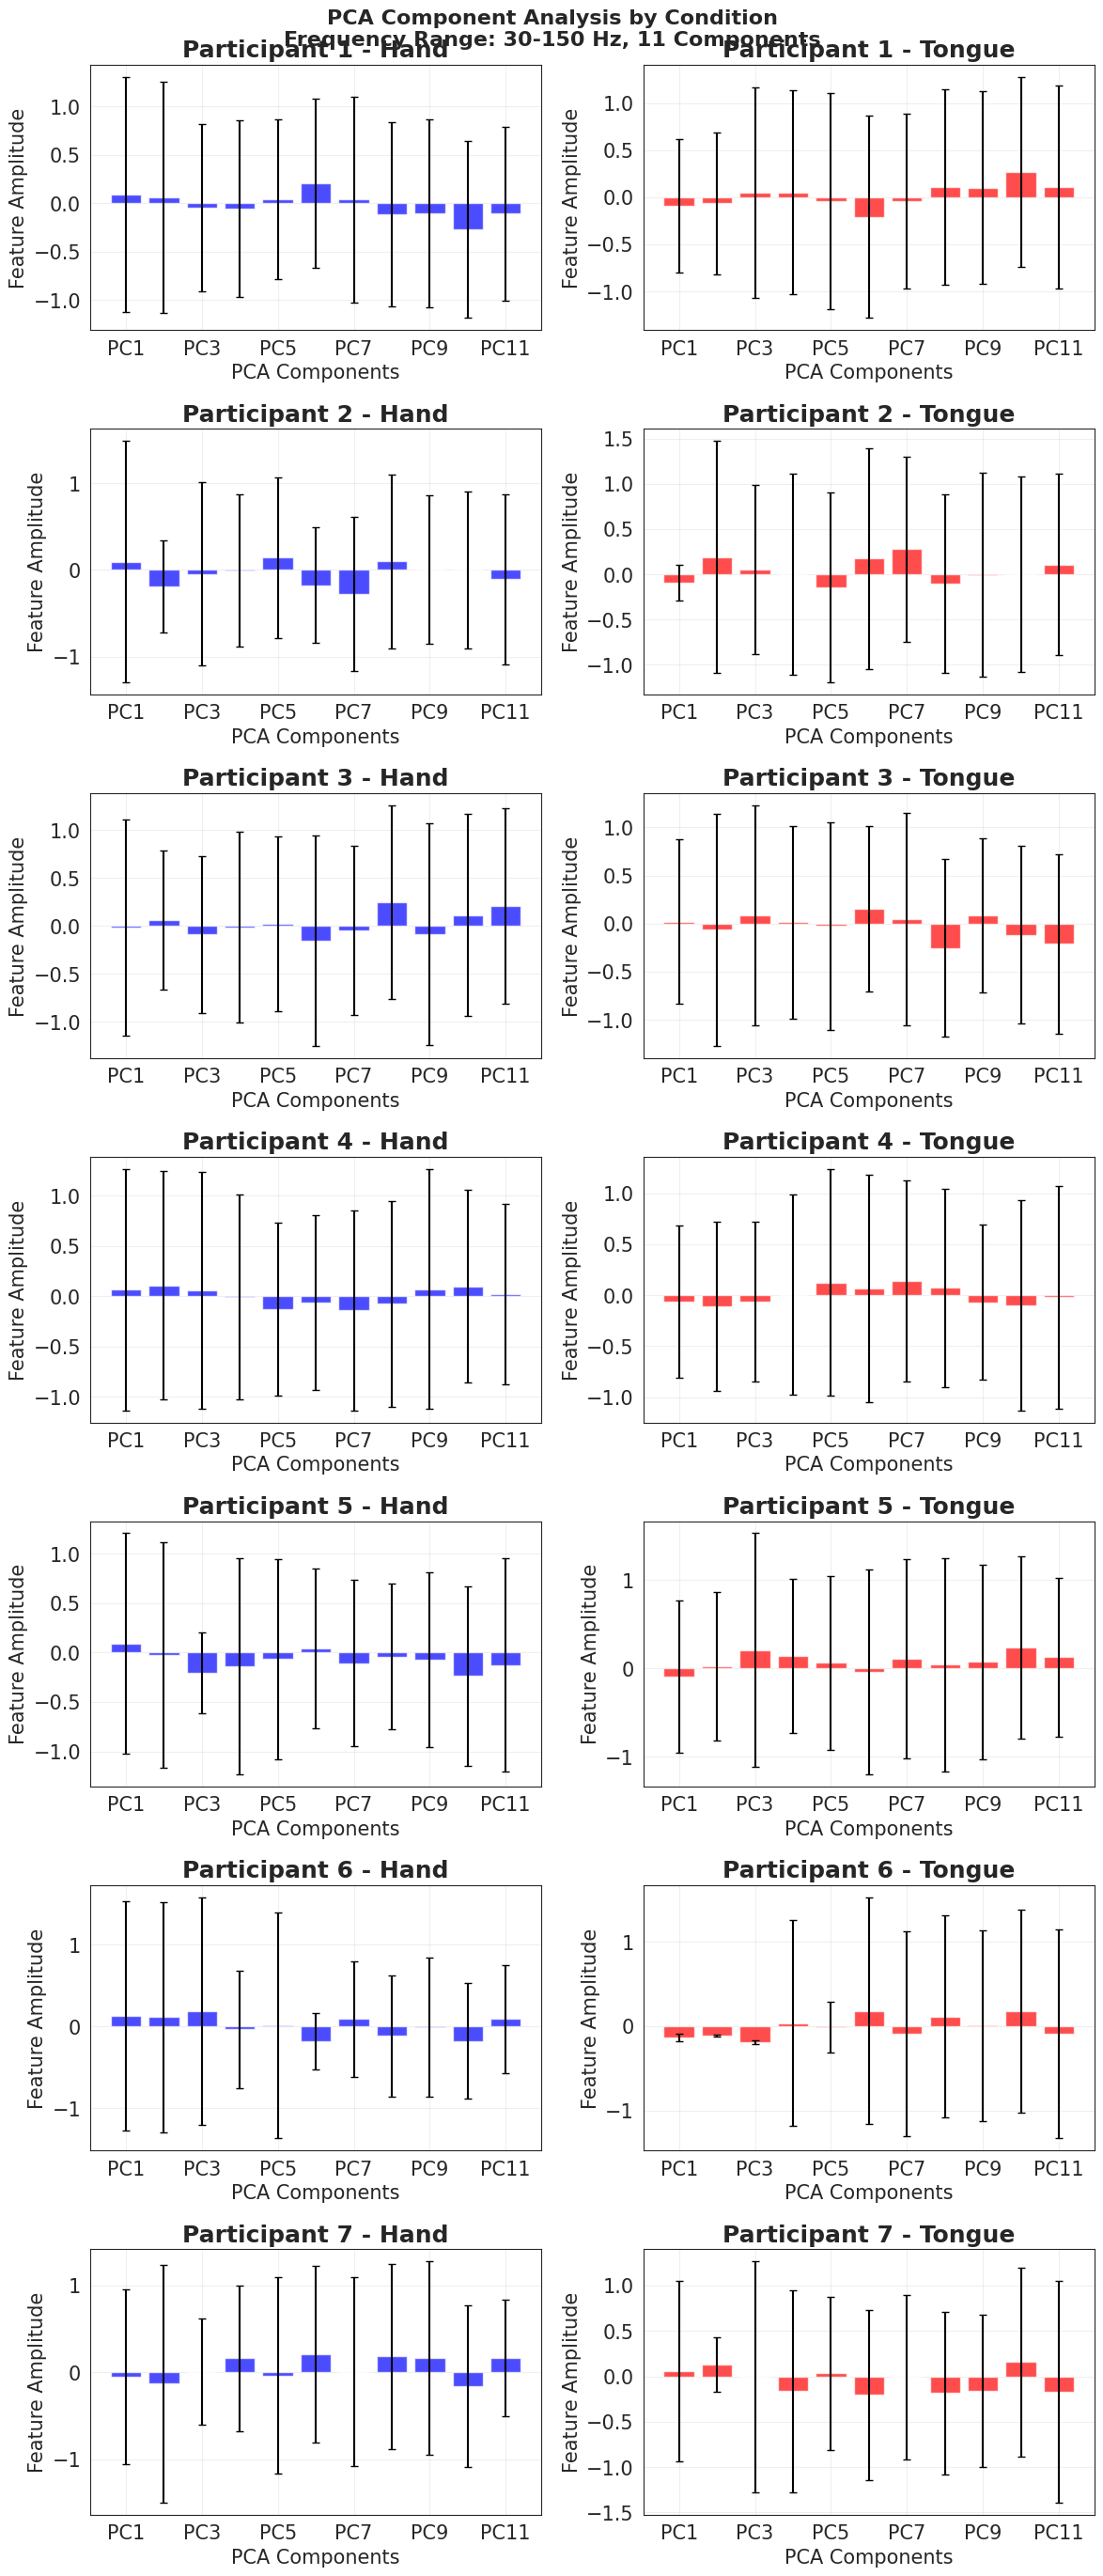

In [15]:
def pca_components(X_unified, y_unified, participant_ids,
                               event_id={'hand': 12, 'tongue': 11},
                               n_components=11,
                               fmin=30, fmax=150):
    """
    Show PCA components as bars for each condition.
    """

    # Get unique participants
    unique_participants = np.unique(participant_ids)
    n_participants = len(unique_participants)

    fig, axes = plt.subplots(n_participants, len(event_id),
                            figsize=(6*len(event_id), 4*n_participants))

    if n_participants == 1:
        axes = axes.reshape(1, -1)
    if len(event_id) == 1:
        axes = axes.reshape(-1, 1)

    for p_idx, participant_id in enumerate(unique_participants):
        participant_mask = participant_ids == participant_id
        X_participant = X_unified[participant_mask]
        y_participant = y_unified[participant_mask]

        for c_idx, (condition, event_code) in enumerate(event_id.items()):
            condition_mask = y_participant == event_code
            if np.sum(condition_mask) > 0:
                condition_data = X_participant[condition_mask]

                # Average across trials
                avg_features = np.mean(condition_data, axis=0)
                std_features = np.std(condition_data, axis=0)

                ax = axes[p_idx, c_idx] if n_participants > 1 else axes[c_idx]

                # Create bar plot of PCA components
                x_pos = np.arange(len(avg_features))
                bars = ax.bar(x_pos, avg_features, yerr=std_features,
                             capsize=3, alpha=0.7, color='blue' if condition == 'hand' else 'red')

                ax.set_title(f'Participant {participant_id+1} - {condition.title()}',
                           fontweight='bold')
                ax.set_xlabel('PCA Components')
                ax.set_ylabel('Feature Amplitude')
                ax.set_xticks(x_pos[::max(1, len(x_pos)//5)])
                ax.set_xticklabels([f'PC{i+1}' for i in range(0, len(x_pos), max(1, len(x_pos)//5))])
                ax.grid(True, alpha=0.3)

    plt.suptitle(f'PCA Component Analysis by Condition\n'
                f'Frequency Range: {fmin}-{fmax} Hz, {n_components} Components',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return fig

fig2 = pca_components(
    X_unified, y_unified, participant_ids,
    event_id={'hand': 12, 'tongue': 11},
    n_components=11,
    fmin=30, fmax=150
)

## Training and testing

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [17]:
event_id={'hand': 12, 'tongue': 11}
valid_labels = list(event_id.values())
valid_mask = np.isin(y_unified, valid_labels)

X_filtered = X_unified[valid_mask]
y_filtered = y_unified[valid_mask]
participant_ids_filtered = participant_ids[valid_mask]

print(f"Filtered dataset: {X_filtered.shape[0]} trials")

label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y_filtered)

# Get label names for interpretation
label_names = [list(event_id.keys())[list(event_id.values()).index(label)]
                for label in label_encoder.classes_]
print(f"Binary mapping: {dict(zip(range(len(label_names)), label_names))}")

unique, counts = np.unique(y_binary, return_counts=True)
print(f"Class distribution:")
for i, (label, count) in enumerate(zip(label_names, counts)):
    print(f"  {label}: {count} trials")

X_train, X_test, y_train, y_test, pid_train, pid_test = train_test_split(
    X_filtered, y_binary, participant_ids_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print(f"\nTrain set: {X_train.shape[0]} trials")
print(f"Test set: {X_test.shape[0]} trials")

Filtered dataset: 420 trials
Binary mapping: {0: 'tongue', 1: 'hand'}
Class distribution:
  tongue: 210 trials
  hand: 210 trials

Train set: 336 trials
Test set: 84 trials


In [18]:
def analyze_per_participant(X_test, y_test, y_test_pred, pid_test, label_names):
    unique_participants = np.unique(pid_test)

    print(f"\nPer-Participant Analysis:")
    participant_accuracies = []
    for pid in unique_participants:
        mask = pid_test == pid
        if np.sum(mask) > 0:
            y_true_p = y_test[mask]
            y_pred_p = y_test_pred[mask]
            accuracy_p = accuracy_score(y_true_p, y_pred_p)
            participant_accuracies.append(accuracy_p)

            print(f"Participant {pid+1}: {accuracy_p:.3f} ({np.sum(mask)} trials)")

In [19]:
def create_classification_plots(y_test, y_test_pred, y_test_proba,
                                feature_importance, label_names,
                                model_type):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)
    plt.subplots_adjust(wspace=0.4)

    # 1) Confusion Matrix
    ax_cm = axes[0]
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar=False, ax=ax_cm)
    ax_cm.set_title('Confusion Matrix', fontweight='bold')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('Actual')

    # 2) Prediction Probability Distribution
    ax_dist = axes[1]
    for i, label in enumerate(label_names):
        mask = (y_test == i)
        ax_dist.hist(y_test_proba[mask, i], bins=20, alpha=0.7,
                     density=True, label=f'True {label}')
    ax_dist.set_title('Prediction Probability Distribution', fontweight='bold')
    ax_dist.set_xlabel('Probability')
    ax_dist.set_ylabel('Density')
    ax_dist.legend()
    ax_dist.grid(True, alpha=0.3)

    plt.suptitle(f'{model_type} Classification Results', fontsize=16, fontweight='bold')
    plt.show()

In [20]:
def train_logistic_regression(X_unified, y_unified, participant_ids,
                             event_id={'hand': 12, 'tongue': 11},
                             test_size=0.2,
                             random_state=42,
                             cross_validate=True):
    lr_model = LogisticRegression(
        random_state=random_state,
        max_iter=1000,
        solver='liblinear'
    )

    lr_model.fit(X_train, y_train)
    y_train_pred = lr_model.predict(X_train)
    y_test_pred = lr_model.predict(X_test)
    y_train_proba = lr_model.predict_proba(X_train)
    y_test_proba = lr_model.predict_proba(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"\nResults:")
    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    # Cross-validation
    if cross_validate:
        print(f"\nCross-Validation:")
        cv_scores = cross_val_score(lr_model, X_filtered, y_binary,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
                                   scoring='accuracy')
        print(f"CV Accuracy: {cv_scores.mean():.3f}")
        print(f"CV Scores: {[f'{score:.3f}' for score in cv_scores]}")

    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=label_names))

    feature_importance = np.abs(lr_model.coef_[0])
    top_features_idx = np.argsort(feature_importance)[-10:]

    print(f"\nTop 10 Most Important Features:")
    for i, idx in enumerate(reversed(top_features_idx)):
        print(f"{i+1:2d}. Feature {idx:2d}: {feature_importance[idx]:.4f}")

    create_classification_plots(y_test, y_test_pred, y_test_proba,
                               feature_importance, label_names, model_type="Logistic Regression")

    analyze_per_participant(X_test, y_test, y_test_pred, pid_test, label_names)

    return lr_model, label_encoder, {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_scores': cv_scores if cross_validate else None,
        'feature_importance': feature_importance,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba,
        'label_names': label_names
    }

In [21]:
def train_svm(X_unified, y_unified, participant_ids,
              event_id={'hand': 12, 'tongue': 11},
              test_size=0.2,
              random_state=42,
              cross_validate=True):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\nTraining SVM (RBF kernel):")
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=random_state,
        probability=True
    )

    svm_model.fit(X_train_scaled, y_train)
    y_train_pred = svm_model.predict(X_train_scaled)
    y_test_pred = svm_model.predict(X_test_scaled)
    y_train_proba = svm_model.predict_proba(X_train_scaled)
    y_test_proba = svm_model.predict_proba(X_test_scaled)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"\nResults:")
    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    # Cross-validation
    if cross_validate:
        print(f"\nCross-Validation:")
        X_all_scaled = scaler.fit_transform(X_filtered)
        cv_scores = cross_val_score(svm_model, X_all_scaled, y_binary,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
                                   scoring='accuracy')
        print(f"CV Accuracy: {cv_scores.mean():.3f}")
        print(f"CV Scores: {[f'{score:.3f}' for score in cv_scores]}")

    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=label_names))

    print(f"\nSVM Model:")
    print(f"Number of support vectors: {svm_model.n_support_}")
    print(f"Support vector ratio: {svm_model.n_support_.sum() / len(X_train_scaled):.3f}")

    create_classification_plots(y_test, y_test_pred, y_test_proba,
                               np.ones(X_train.shape[1]), label_names, model_type="SVM")

    analyze_per_participant(X_test, y_test, y_test_pred, pid_test, label_names)

    return svm_model, label_encoder, scaler, {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_scores': cv_scores if cross_validate else None,
        'n_support_vectors': svm_model.n_support_,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba,
        'label_names': label_names
    }

In [22]:
def train_random_forest(X_unified, y_unified, participant_ids,
                       event_id={'hand': 12, 'tongue': 11},
                       test_size=0.2,
                       random_state=42,
                       cross_validate=True,
                       n_estimators=100):
    print(f"\nTraining Random Forest ({n_estimators} trees)")
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True
    )

    rf_model.fit(X_train, y_train)
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    y_train_proba = rf_model.predict_proba(X_train)
    y_test_proba = rf_model.predict_proba(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"\nResults:")
    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    if cross_validate:
        print(f"\nCross-Validation:")
        cv_scores = cross_val_score(rf_model, X_filtered, y_binary,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
                                   scoring='accuracy')
        print(f"CV Accuracy: {cv_scores.mean():.3f}")
        print(f"CV Scores: {[f'{score:.3f}' for score in cv_scores]}")

    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=label_names))

    feature_importance = rf_model.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-10:]

    print(f"\nTop 10 Most Important Features:")
    for i, idx in enumerate(reversed(top_features_idx)):
        print(f"{i+1:2d}. Feature {idx:2d}: {feature_importance[idx]:.4f}")

    create_classification_plots(y_test, y_test_pred, y_test_proba,
                               feature_importance, label_names, model_type="Random Forest")

    analyze_per_participant(X_test, y_test, y_test_pred, pid_test, label_names)

    return rf_model, label_encoder, {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_scores': cv_scores if cross_validate else None,
        'feature_importance': feature_importance,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba,
        'label_names': label_names
    }

In [23]:
def compare_models(X_unified, y_unified, participant_ids,
                  event_id={'hand': 12, 'tongue': 11},
                  test_size=0.2,
                  random_state=42):
    print("---Logistic Regression:---")
    lr_model, lr_encoder, lr_results = train_logistic_regression(
        X_unified, y_unified, participant_ids, event_id, test_size, random_state, True
    )
    print("\n---SVM:---")
    svm_model, svm_encoder, svm_scaler, svm_results = train_svm(
        X_unified, y_unified, participant_ids, event_id, test_size, random_state, True
    )
    print("\n---Random Forest:---")
    rf_model, rf_encoder, rf_results = train_random_forest(
        X_unified, y_unified, participant_ids, event_id, test_size, random_state, True
    )
    print("\nSUMMARY:")
    models_summary = {
        'Logistic Regression': lr_results,
        'SVM': svm_results,
        'Random Forest': rf_results
    }

    print(f"{'Model':<20} {'Train Acc':<10} {'Test Acc':<10} {'CV Mean':<10}")
    print("-" * 30)

    for model_name, results in models_summary.items():
        cv_mean = results['cv_scores'].mean() if results['cv_scores'] is not None else 0
        print(f"{model_name:<20} {results['train_accuracy']:<10.3f} {results['test_accuracy']:<10.3f} "
              f"{cv_mean:<10.3f}")

    # Find best model
    best_model_name = max(models_summary.keys(),
                         key=lambda x: models_summary[x]['test_accuracy'])
    print(f"\nBest performing model: {best_model_name} "
          f"(Test Accuracy: {models_summary[best_model_name]['test_accuracy']:.3f})")

    return {
        'logistic_regression': (lr_model, lr_encoder, lr_results),
        'svm': (svm_model, svm_encoder, svm_scaler, svm_results),
        'random_forest': (rf_model, rf_encoder, rf_results),
        'best_model': best_model_name
    }

---Logistic Regression:---

Results:
Training Accuracy: 0.568
Test Accuracy: 0.536

Cross-Validation:
CV Accuracy: 0.464
CV Scores: ['0.452', '0.500', '0.488', '0.429', '0.452']

Classification Report (Test Set):
              precision    recall  f1-score   support

      tongue       0.53      0.57      0.55        42
        hand       0.54      0.50      0.52        42

    accuracy                           0.54        84
   macro avg       0.54      0.54      0.54        84
weighted avg       0.54      0.54      0.54        84


Top 10 Most Important Features:
 1. Feature  9: 0.1836
 2. Feature  6: 0.1150
 3. Feature  0: 0.1132
 4. Feature  5: 0.0695
 5. Feature  2: 0.0622
 6. Feature  4: 0.0466
 7. Feature 10: 0.0400
 8. Feature  7: 0.0393
 9. Feature  1: 0.0213
10. Feature  8: 0.0107


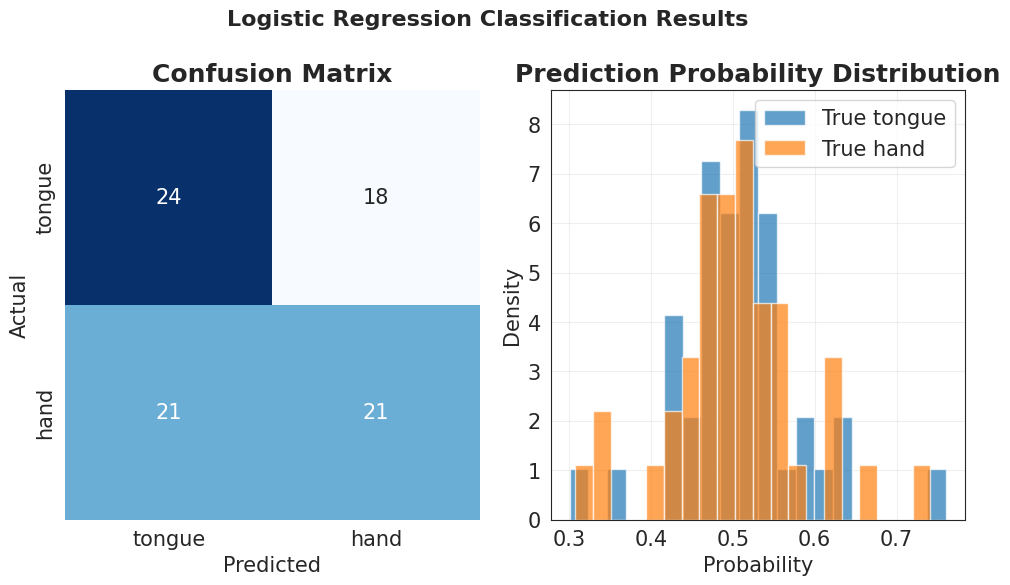


Per-Participant Analysis:
Participant 1: 1.000 (7 trials)
Participant 2: 0.636 (11 trials)
Participant 3: 0.400 (10 trials)
Participant 4: 0.357 (14 trials)
Participant 5: 0.643 (14 trials)
Participant 6: 0.538 (13 trials)
Participant 7: 0.400 (15 trials)

---SVM:---

Training SVM (RBF kernel):

Results:
Training Accuracy: 0.711
Test Accuracy: 0.536

Cross-Validation:
CV Accuracy: 0.452
CV Scores: ['0.476', '0.500', '0.417', '0.464', '0.405']

Classification Report (Test Set):
              precision    recall  f1-score   support

      tongue       0.56      0.33      0.42        42
        hand       0.53      0.74      0.61        42

    accuracy                           0.54        84
   macro avg       0.54      0.54      0.52        84
weighted avg       0.54      0.54      0.52        84


SVM Model:
Number of support vectors: [167 163]
Support vector ratio: 0.982


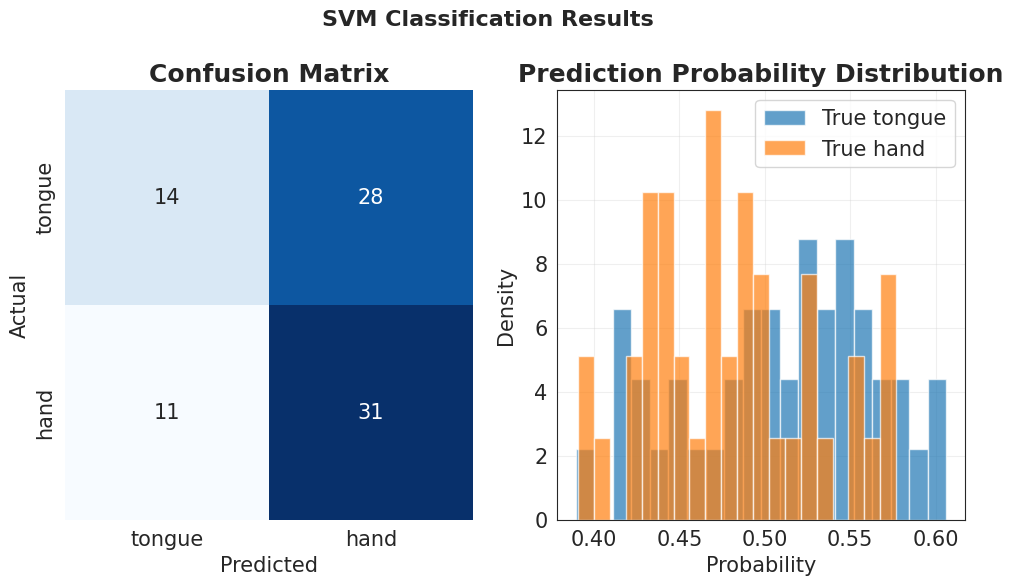


Per-Participant Analysis:
Participant 1: 0.714 (7 trials)
Participant 2: 0.545 (11 trials)
Participant 3: 0.500 (10 trials)
Participant 4: 0.357 (14 trials)
Participant 5: 0.571 (14 trials)
Participant 6: 0.615 (13 trials)
Participant 7: 0.533 (15 trials)

---Random Forest:---

Training Random Forest (100 trees)

Results:
Training Accuracy: 1.000
Test Accuracy: 0.488

Cross-Validation:
CV Accuracy: 0.457
CV Scores: ['0.488', '0.476', '0.512', '0.393', '0.417']

Classification Report (Test Set):
              precision    recall  f1-score   support

      tongue       0.49      0.48      0.48        42
        hand       0.49      0.50      0.49        42

    accuracy                           0.49        84
   macro avg       0.49      0.49      0.49        84
weighted avg       0.49      0.49      0.49        84


Top 10 Most Important Features:
 1. Feature  3: 0.1153
 2. Feature  4: 0.1011
 3. Feature  2: 0.0957
 4. Feature  9: 0.0949
 5. Feature  0: 0.0919
 6. Feature  6: 0.0881
 

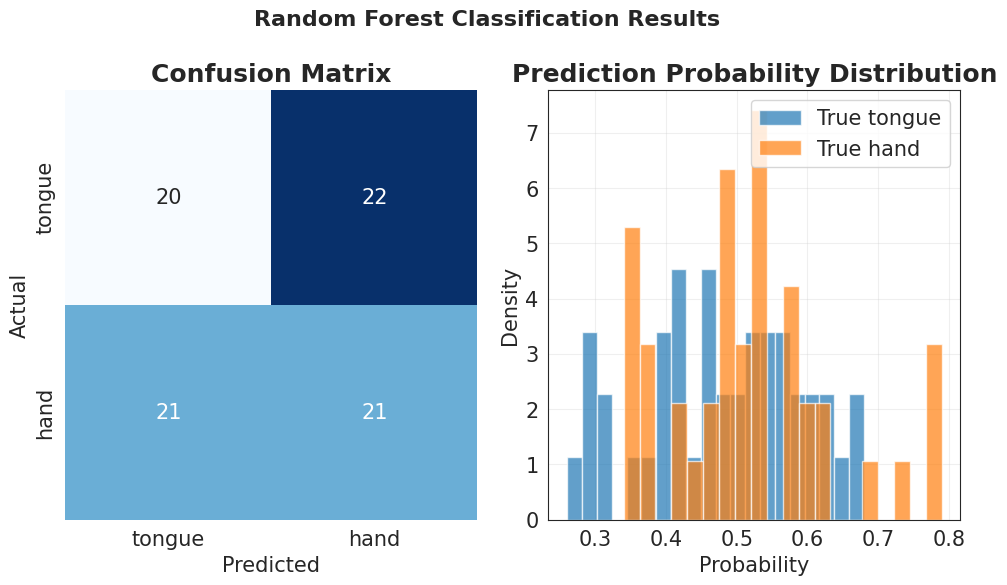


Per-Participant Analysis:
Participant 1: 0.857 (7 trials)
Participant 2: 0.364 (11 trials)
Participant 3: 0.600 (10 trials)
Participant 4: 0.357 (14 trials)
Participant 5: 0.571 (14 trials)
Participant 6: 0.385 (13 trials)
Participant 7: 0.467 (15 trials)

SUMMARY:
Model                Train Acc  Test Acc   CV Mean   
------------------------------
Logistic Regression  0.568      0.536      0.464     
SVM                  0.711      0.536      0.452     
Random Forest        1.000      0.488      0.457     

Best performing model: Logistic Regression (Test Accuracy: 0.536)


In [24]:
all_models = compare_models(X_unified, y_unified, participant_ids)